In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.DataManip.Metric import GetTanimotoSimMat
from rdkit.Chem import DataStructs

#descripts
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA

# plots
from matplotlib import pyplot
import seaborn

import itertools
from itertools import combinations

import numpy as np

from sklearn.metrics import jaccard_score

import os

Funkce function_pro je napsana pro vypocet prumerne Tanimotove vzdalenosti a poctu zastupcu jednotliveho biologickeho cilu

In [2]:
def function_pro(df):
    prumery = pd.DataFrame(columns = ['pref_name', 'prumerna_Tanimota',
                                      'pocet_zastupcu'])
    sparse_mat = distance.pdist(list(df["mfp"]),metric="jaccard")
    dist_mat = distance.squareform(sparse_mat)
    pref_name = df['pref_name'][0]
    mean = dist_mat.mean()
    pocet = df.shape[0]   
    prumery.loc[len(prumery)] = [pref_name,mean,pocet]
    return prumery

Vizualizace jednotlive diversity ligandu, pomoci shlukove analyzy T-SNE

In [6]:
def vizualiza_T_SNE(df,names):
    #mfp = []
    #mfp = [[df['mfp'][x]] for x in range(len(df))]
    #print(mfp)
    #print(mfp.shape)
    #pca = PCA(n_components=50)
    #pca.fit(mfp)
    #pca_ = pca.transform(dist_mat)
    #print(pca_.shape)
    sparse_mat = distance.pdist(list(df["mfp"]),metric="jaccard")
    dist_mat = distance.squareform(sparse_mat)
    #print(dist_mat.shape)
    #clf = manifold.TSNE(n_components=2, metric="precomputed")
    #X_tsne = clf.fit_transform(pca_)
    #df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x_after_PCA", "tsne_y_after_PCA"]))
    
    clf = manifold.TSNE(n_components=2, metric="precomputed")
    X_tsne = clf.fit_transform(dist_mat)
    df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))
    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="pref_name",
                      legend="brief",
                      ax=ax,
                      alpha=1
                     ).set(title=f't-SNE pro {names} biologicke cile')
    


Nacitani jednotlivych dat, podle promenne "name" se meni trida ktera bude nacitana

In [7]:
def nacitani_dat_zpracovani(names):
    df = pd.DataFrame(columns = ['molregno', 'stand_type', 
                                    'pchembl_value', 'stand_value',
                                    'canonical_smiles', 'stand_inchi',
                                   'chembl_id', 'tid','pref_name', 'mfp'])
    prumery = pd.DataFrame(columns = ['pref_name', 'prumerna_Tanimota',
                                      'pocet_zastupcu'])

    for root, dirs, files in os.walk(f"../../../postgres/chembl_data/sets/{names}/", topdown=False):
        for name in files:
            list_ = pd.read_pickle(f"{root}{name}")
            dff = pd.DataFrame(list_, columns = ['molregno', 'stand_type', 
                                    'pchembl_value', 'stand_value',
                                    'canonical_smiles', 'stand_inchi',
                                   'chembl_id', 'tid','pref_name'])
            dff['mfp'] =dff['canonical_smiles'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(MurckoScaffoldSmiles(x)), 3, nBits = 2048))
            
            #dff['mfp'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(MurckoScaffoldSmiles(i)), 3, nBits = 2048)) for i in dff['canonical_smiles']]
            prumer = function_pro(dff)
            prumery = pd.concat([prumery, prumer])
            df = pd.concat([df, dff])
    df.reset_index(level=0, inplace=True)
    prumery.reset_index(level=0, inplace=True)
    prumery = prumery.drop(['index'], axis = 1)
    prumery = prumery.sort_values(by=['prumerna_Tanimota'],ascending=False )
    print(f"Pro {names} biologicke cile:")
    display(prumery)
    vizualiza_T_SNE(df,names)
    

Pro nuclear biologicke cile:


,pref_name,prumerna_Tanimota,pocet_zastupcu
9,LXR-alpha,0.851672,123
7,Estrogen receptor alpha,0.849602,96
2,Bile acid receptor FXR,0.842068,194
8,Peroxisome proliferator-activated receptor gamma,0.841492,513
4,LXR-beta,0.836351,145
11,Estrogen receptor beta,0.829245,77
3,Nuclear receptor ROR-gamma,0.828853,125
1,Retinoid X receptor alpha,0.828275,52
6,Peroxisome proliferator-activated receptor delta,0.827233,196
0,Peroxisome proliferator-activated receptor alpha,0.824099,390


/home/filv/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/filv/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


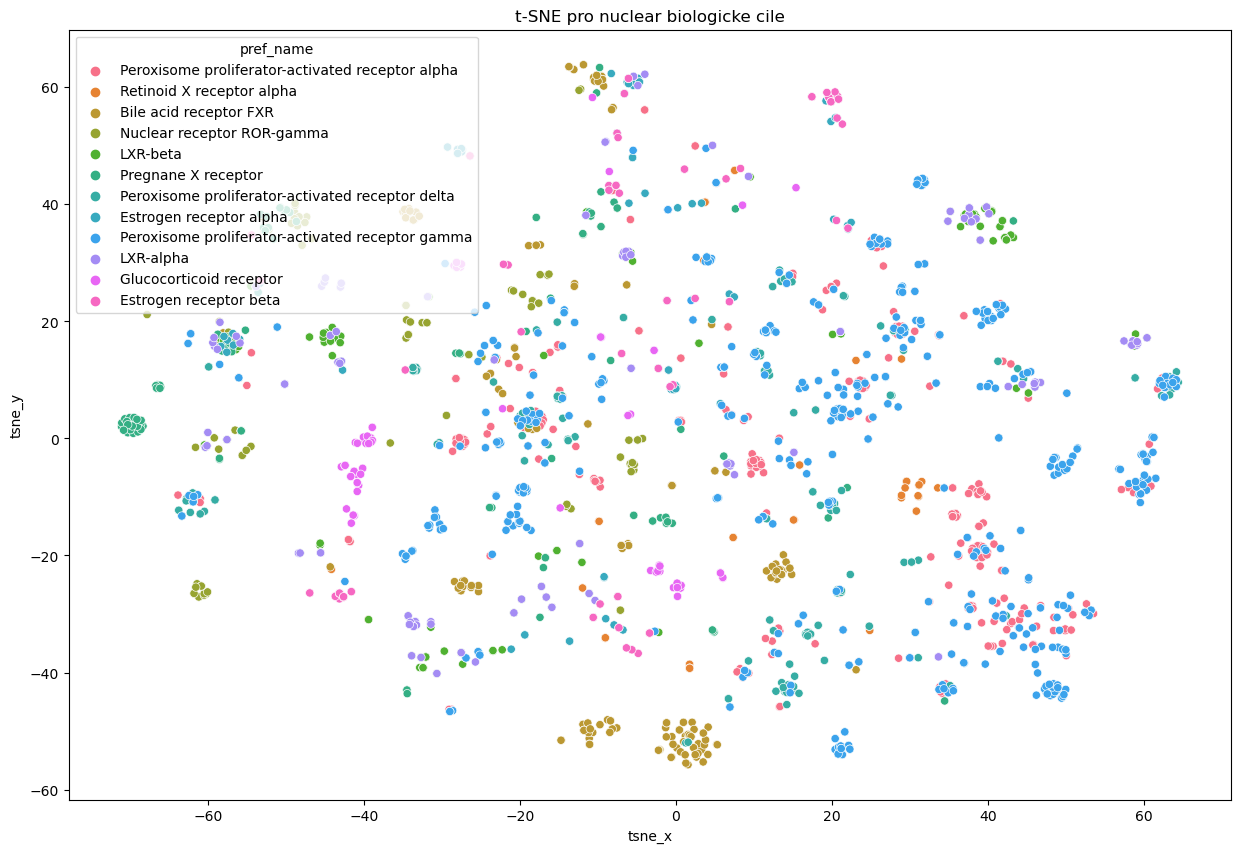

In [8]:
nacitani_dat_zpracovani('nuclear')

Pro protease biologicke cile:


,pref_name,prumerna_Tanimota,pocet_zastupcu
32,Beta-secretase 1,0.876812,914
25,Cathepsin K,0.872280,108
12,Matrix metalloproteinase 3,0.862607,129
26,Matrix metalloproteinase-2,0.859496,280
29,Coagulation factor X,0.855751,244
22,Thrombin,0.853386,262
34,ADAM17,0.851500,157
2,Leukocyte elastase,0.850845,102
9,Caspase-3,0.850841,104
1,Matrix metalloproteinase 9,0.848607,173


/home/filv/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/filv/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


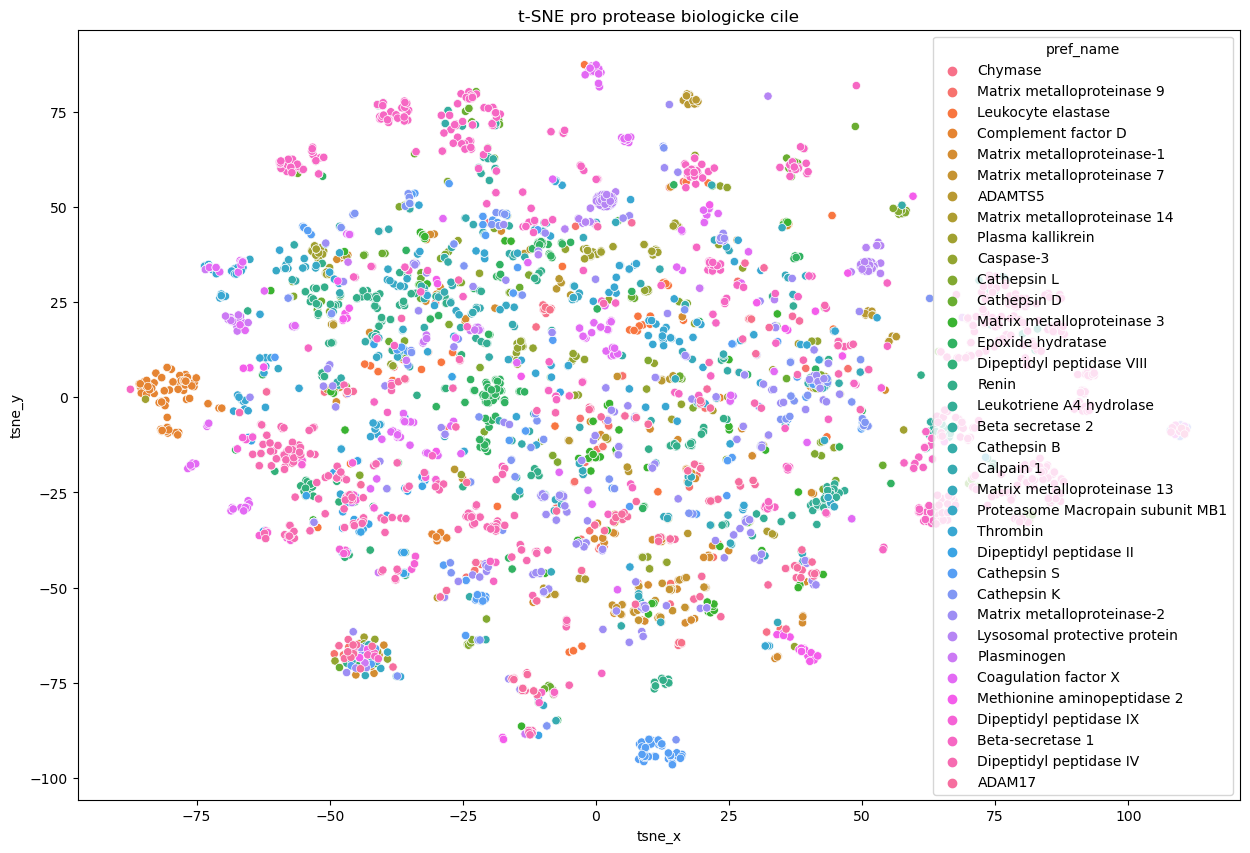

In [9]:
nacitani_dat_zpracovani('protease')